In [1]:
import keras.models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os


def relative_strength_index(df, n=14):
    """Calculate Relative Strength Index(RSI) for given data.

    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    return RSI


def macd(df, n_fast=26, n_slow=12):
    """Calculate MACD, MACD Signal and MACD difference

    :param df: pandas.DataFrame
    :param n_fast:
    :param n_slow:
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df


def moving_average(df, n):
    """Calculate the moving average for the given data.

    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df


In [3]:
#df = pd.read_csv("..//ProcessingData//BTC Minute CSVs//BTCUSER_all_processed.csv")
# df = pd.read_csv("gemini_BTCUSD_2021_1min.csv")
df = pd.read_parquet('../ProcessingData/BTC Minute CSVs/BTCUSER_all_processed.parquet')
# df.head()
indexes = [i for i in range(0, len(df)) if i % (30) == 0]
temp = df.iloc[indexes]
temp = temp.loc[df['Date'] > '2019-06-01 00:00:00']
df = temp
# df = macd(df)
# df = moving_average(df, 14)
# df = df.join(relative_strength_index(df))
df = df['Open'].values
df = df.reshape(-1, 1)
print(df.shape)
print(df[:5])
dataset_train = np.array(df[:int(df.shape[0] * 0.8)])
dataset_test = np.array(df[int(df.shape[0] * 0.8) - 50:])
print(dataset_train.shape)
print(dataset_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)


def create_dataset(df, lb, steps_into_future):
    x = []
    y = []
    for i in range(lb, df.shape[0] - steps_into_future):
        x.append(df[i - lb:i, 0])
        y.append(df[i:i + steps_into_future, 0])
    x = np.array(x)
    y = np.array(y)
    return x, y

lb = 50
steps_into_future = 50
x_train, y_train = create_dataset(dataset_train, lb, steps_into_future)
x_test, y_test = create_dataset(dataset_test, lb, steps_into_future)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


(42090, 1)
[[8516.2]
 [8516.2]
 [8516.2]
 [8516.2]
 [8516.2]]
(33672, 1)
(8468, 1)


In [4]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=steps_into_future))
model.compile(loss='mean_squared_error', optimizer='adam')


# if not os.path.exists('stock_prediction_rsi.h5'):

# model = load_model('stock_prediction_rsi.h5')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "e:\repos\ai-predictie-de-pret\processingdata\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\petru\AppData\Local\Temp/ipykernel_21724/890023543.py", line 8, in <module>
    model.add(LSTM(units=96))
  File "e:\repos\ai-predictie-de-pret\processingdata\venv\lib\site-packages\tensorflow\python\training\tracking\base.py", line 530, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "e:\repos\ai-predictie-de-pret\processingdata\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "e:\repos\ai-predictie-de-pret\processingdata\venv\lib\site-packages\keras\engine\sequential.py", line 220, in add
    output_tensor = layer(self.outputs[0])
  File "e:\repos\ai-predictie-de-pret\processingdata\venv\lib\site-packages\keras\layers\recurrent.py", line 679, in __call__
   

TypeError: object of type 'NoneType' has no len()

In [63]:
for i in range(1, 100):
    model.fit(x_train, y_train, epochs=10,validation_data=(x_test,y_test), batch_size=32)
    model.save(f'stock_prediction_{i}_steps')


Epoch 1/10
1050/1050 [==============================] - 205s 195ms/step - loss: 5.3936e-04 - val_loss: 5.8145e-04
Epoch 2/10
1050/1050 [==============================] - 231s 220ms/step - loss: 5.6237e-04 - val_loss: 0.0021
Epoch 3/10
1050/1050 [==============================] - 211s 201ms/step - loss: 5.3399e-04 - val_loss: 6.6215e-04
Epoch 4/10
1050/1050 [==============================] - 253s 241ms/step - loss: 5.3280e-04 - val_loss: 0.0016
Epoch 5/10
1050/1050 [==============================] - 248s 236ms/step - loss: 5.4676e-04 - val_loss: 0.0012
Epoch 6/10
1050/1050 [==============================] - 237s 226ms/step - loss: 5.3473e-04 - val_loss: 8.7935e-04
Epoch 7/10
1050/1050 [==============================] - 266s 253ms/step - loss: 5.1912e-04 - val_loss: 6.1263e-04
Epoch 8/10
1050/1050 [==============================] - 239s 228ms/step - loss: 5.0458e-04 - val_loss: 8.4679e-04
Epoch 9/10
1050/1050 [==============================] - 245s 234ms/step - loss: 5.2422e-04 - val_los

INFO:tensorflow:Assets written to: stock_prediction_1_steps\assets


INFO:tensorflow:Assets written to: stock_prediction_1_steps\assets


Epoch 1/10
1050/1050 [==============================] - 258s 246ms/step - loss: 5.0798e-04 - val_loss: 9.9088e-04
Epoch 2/10
1050/1050 [==============================] - 239s 228ms/step - loss: 5.1728e-04 - val_loss: 6.2426e-04
Epoch 3/10
1050/1050 [==============================] - 247s 236ms/step - loss: 5.0471e-04 - val_loss: 7.0129e-04
Epoch 4/10
1050/1050 [==============================] - 262s 250ms/step - loss: 4.9959e-04 - val_loss: 5.2435e-04
Epoch 5/10
 285/1050 [=======>......................] - ETA: 3:24 - loss: 4.8374e-04

KeyboardInterrupt: 

In [5]:
model = keras.models.load_model('stock_prediction_1_steps')
predictions = model.predict(x_test)

# predictions = scaler.inverse_transform(predictions)
#
# fig, ax = plt.subplots(figsize=(8, 4))
# plt.plot(df, color='red',  label="True Price")
# ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)), predictions, color='blue', label='Predicted Testing Price')
# plt.legend()
# plt.show()
#
#
#
# y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
#
# fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(y_test_scaled, color='red', label='True Testing Price')
# plt.plot(predictions, color='blue', label='Predicted Testing Price')
# plt.legend()
# plt.show()

KeyboardInterrupt: 

In [51]:
y_test

array([[0.54892089, 0.55015309, 0.54482257, ..., 0.52603445, 0.524644  ,
        0.5250266 ],
       [0.55015309, 0.54482257, 0.54562947, ..., 0.524644  , 0.5250266 ,
        0.52149616],
       [0.54482257, 0.54562947, 0.54201513, ..., 0.5250266 , 0.52149616,
        0.52193068],
       ...,
       [0.82149949, 0.81715506, 0.81739573, ..., 0.74379144, 0.73878484,
        0.73530138],
       [0.81715506, 0.81739573, 0.81681433, ..., 0.73878484, 0.73530138,
        0.74236918],
       [0.81739573, 0.81681433, 0.81747337, ..., 0.73530138, 0.74236918,
        0.7469378 ]])

In [34]:
predictions

array([[0.55215603, 0.55220795, 0.552276  , ..., 0.5552558 , 0.5554717 ,
        0.55555886],
       [0.5521948 , 0.5522468 , 0.55231524, ..., 0.5553005 , 0.55551684,
        0.55560374],
       [0.5523751 , 0.55242705, 0.5524955 , ..., 0.55548394, 0.5557006 ,
        0.55578744],
       ...,
       [0.84235036, 0.8420682 , 0.8420072 , ..., 0.84025073, 0.84024286,
        0.8404107 ],
       [0.83917964, 0.83890474, 0.8388479 , ..., 0.8372356 , 0.83723354,
        0.83740246],
       [0.8362407 , 0.83597255, 0.835919  , ..., 0.8344349 , 0.83443767,
        0.8346075 ]], dtype=float32)

In [58]:
# y_test_scaled = scaler.inverse_transform(y_test[0].reshape(-1, 1))
# predictions_scaled = scaler.inverse_transform(predictions[0].reshape(-1, 1))
#nu trebuie facut asa in aplicatia finala! am facut asa pentru ca nu aveam mult timp la dispozitie
#in practica trebuie trimis un singur input si obtinut un output care e 50 de valori pe care le afisam
all_test_lines = np.concatenate(y_test)
all_test_predictions = np.concatenate(predictions)

In [62]:
y_test_scaled = scaler.inverse_transform(all_test_lines.reshape(-1, 1))
predictions_scaled = scaler.inverse_transform(all_test_predictions.reshape(-1, 1))

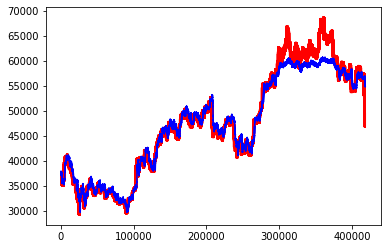

In [61]:
plt.plot(y_test_scaled, color='red', label='Actual Prices')
plt.plot(predictions_scaled, color='blue', label='Predicted Prices')